In [127]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [140]:
OUTPUT_DATA = True

In [137]:
scriptDir = os.getcwd() # Assumes that script is executed from its actual location
relPath = r"../data/" # And data is located in a 'data' folder in the same parent directory as 'code' folder
trainFilePath = os.path.join(scriptDir, relPath,"train.csv")
valFilePath = os.path.join(scriptDir, relPath,"validation.csv")
sampleFilePath = os.path.join(scriptDir, relPath,"sample.csv")
relPathOutput = r"../output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

In [114]:
# Load data into pandas dataframe
df = pd.read_csv(trainFilePath, sep=',',header=0, quotechar='"')

In [115]:
# get min floorprice and max payprice to use as the range of constant bids we will try
minBid = df['slotprice'].min()
maxBid = df['payprice'].max()

In [118]:
def evalConstantBid(df, bidValue, budget=6250*1000, repeat=5):
    # remove everything we wouldn't win, we don't care about it anymore
    dfWon = df[['bidid', 'payprice', 'click']][df['payprice'] <= bidValue].copy()

    results = np.zeros((repeat, 6))
    for iteration in range(repeat):
        # now evaluate sequentially to see what the results are
        # first random sample (taking everything without replacement equivalent to a shuffle)
        # although if only do 1 test, then don't bother
        if repeat > 1:
            dfWon = dfWon.sample(frac=1)
        # now create cumulative spend
        dfWon['cumSpend'] = dfWon['payprice'].cumsum()
        dfWon['cumSpendLead'] = dfWon['cumSpend'].shift(1, fill_value=0)
        dfRes = dfWon[dfWon['cumSpendLead'] <= budget]
        # and get stats
        numClicks = dfRes['click'].sum()
        numImps = dfRes['bidid'].count()
        totalCPM = dfRes['payprice'].sum()
        spend = totalCPM / 1000

        if numImps > 0:
            CTR = numClicks / numImps
            aveCPM = totalCPM / numImps
        else:
            CTR = np.NaN
            aveCPM = np.NaN

        if numClicks > 0:
            aveCPC = spend / numClicks
        else:
            aveCPC = np.NaN
        
        results[iteration,:] = np.array([numImps, numClicks, CTR, spend, aveCPM, aveCPC])
        
    resultsMean = np.mean(results, axis=0)
        
    return resultsMean



In [119]:
# this takes a long time to run on training data (>20 mins)
# because for the high bid values, it basically ends up copying+shuffling the entire dataset
bids = list(range(minBid, maxBid+1))
results = np.zeros((len(bids), 7)) # to store results
for bidIdx in range(len(bids)):
    bidValue = bids[bidIdx]
    results[bidIdx, 0] = bidValue
    results[bidIdx, 1:7] = evalConstantBid(df, bidValue)

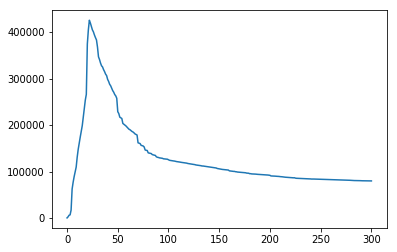

In [141]:
# Impressions won
plt.plot(bids, results[:,1]);
if OUTPUT_DATA: plt.savefig(os.path.join(outputFolderPath, 'const_bid_imps.png'));

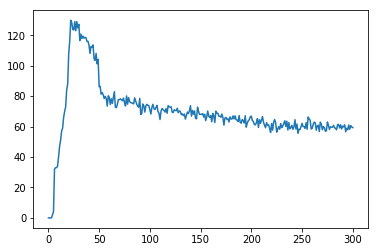

In [143]:
# Clicks
plt.plot(bids, results[:,2]);
if OUTPUT_DATA: plt.savefig(os.path.join(outputFolderPath, 'const_bid_clicks.png'));

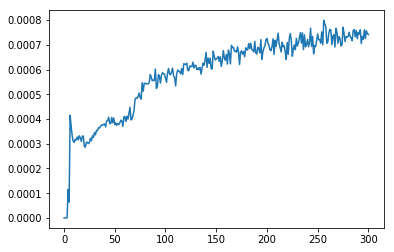

In [144]:
# CTR
plt.plot(bids, results[:,3]);
if OUTPUT_DATA: plt.savefig(os.path.join(outputFolderPath, 'const_bid_CTR.png'));

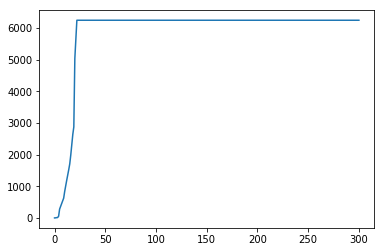

In [145]:
# Spend (Fen)
plt.plot(bids, results[:,4]);
if OUTPUT_DATA: plt.savefig(os.path.join(outputFolderPath, 'const_bid_spend.png'));

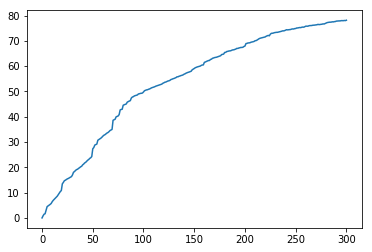

In [146]:
# average CPM
plt.plot(bids, results[:,5]);
if OUTPUT_DATA: plt.savefig(os.path.join(outputFolderPath, 'const_bid_aCPM.png'));

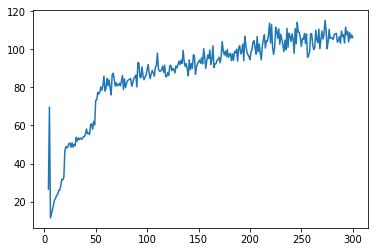

In [147]:
# average CPC
plt.plot(bids, results[:,6]);
if OUTPUT_DATA: plt.savefig(os.path.join(outputFolderPath, 'const_bid_aCPC.png'));

In [126]:
# It took a while to run, so save these results!
if OUTPUT_DATA: np.savetxt(r"../output/const_bid_train_results.csv", results, delimiter=",",fmt='%20.10f')

In [179]:
# What is actual optimum bid value?
#c=['bidValue', 'numImps', 'numClicks', 'CTR', 'spend', 'aveCPM', 'aveCPC']
#resDf = pd.DataFrame(data=results, index=results[:,0], columns=c)
optBid = results[np.argmax(results[:,2]), 0]
optBid #show

22.0

In [176]:
# Note the number of clicks chart, clearly there is an optimum constant bid value
# Will this still apply to the smaller validation dataset?

valDf = pd.read_csv(valFilePath, sep=',',header=0, quotechar='"')
resultsVal = np.zeros((len(bids), 7)) # to store results
for bidIdx in range(len(bids)):
    bidValue = bids[bidIdx]
    resultsVal[bidIdx, 0] = bidValue
    resultsVal[bidIdx, 1:7] = evalConstantBid(valDf, bidValue, repeat=1)

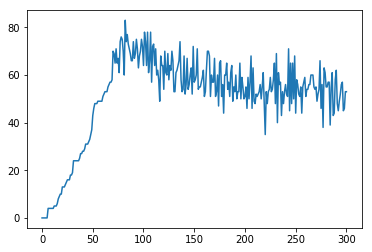

In [177]:
# Clicks
plt.plot(bids, resultsVal[:,2]);
# Here we see that the highest return comes from a much greater bid value than seen on the training set

In [178]:
optBidVal = resultsVal[np.argmax(resultsVal[:,2]), 0]
if OUTPUT_DATA: np.savetxt(r"../output/const_bid_val_results.csv", results, delimiter=",",fmt='%20.10f')
optBidVal #show

82.0

In [ ]:
# Is there some way we could have adjusted the result on the training set for the validation and test set?
# Or is this just a limitation of the constant bidding strategy?